# Master TWAP Analysis by Threshold

This notebook provides a comprehensive analysis of FOX price impact from both **Shapeshift DAO TWAPs** and **Foundation TWAPs** using threshold-based regression analysis.

## Key Features:
1. Loads FOX market data, DAO TWAPs, and Foundation TWAPs
2. Converts Foundation TWAPs to FOX-denominated amounts
3. Computes 7-day normalized volume and threshold-based splits
4. Estimates multiple regression models by volume threshold
5. Analyzes combined impact of DAO + Foundation TWAPs
6. Includes robustness checks (Newey-West, SARIMAX, Random Forest)
7. Comprehensive visualizations

Significance: `***` p<0.01, `**` p<0.05, `*` p<0.10


In [ ]:
# Import validation helpers
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

try:
    from validation_helpers import (
        validate_price_data,
        validate_amounts,
        validate_returns,
        validate_regression_results,
        run_all_validations,
        print_validation_results
    )
    VALIDATION_AVAILABLE = True
    print("✓ Validation helpers imported")
except ImportError as e:
    VALIDATION_AVAILABLE = False
    print(f"⚠ Validation helpers not available: {e}")

In [ ]:
# Install required packages
%pip install requests pandas statsmodels matplotlib pandas_datareader scikit-learn arch -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import libraries
import requests
import pandas as pd
import numpy as np
import time
import os
from datetime import datetime, timedelta
from pandas_datareader import data as pdr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from arch import arch_model
from scipy import stats
from typing import Dict, Tuple, List, Optional


## Configuration


In [ ]:
# Configuration
API_KEY = 'CG-yPxFQKgg39eUzy3NYF2o9Gpu'
HEADERS = {'x-cg-api-key': API_KEY}
VS_CURRENCY = 'usd'
DAYS = '365'  # Last 365 days
TWAPS_CSV = '../data/twaps.csv'  # DAO TWAPs CSV file
FOUNDATION_TWAPS_CSV = '../data/foundation_twap_sales.csv'  # Foundation TWAPs CSV
CACHE_MAX_AGE_HOURS = 24
RATE_LIMIT_DELAY = 2.1  # Delay between API calls (30/min = 1 call every 2 seconds + buffer)
THRESHOLD = -0.539303  # Volume threshold for splitting data


In [ ]:
# Validation: Check market data after loading
if VALIDATION_AVAILABLE and 'df' in locals():
    print("\n" + "="*60)
    print("DATA VALIDATION - Market Data")
    print("="*60)
    
    validation_results = {}
    
    # Validate prices
    if 'price_fox' in df.columns:
        validation_results['price_fox'] = validate_price_data(df, 'price_fox', min_price=0.01, max_price=1000)
    
    if 'vol_fox' in df.columns:
        validation_results['vol_fox'] = validate_amounts(df, 'vol_fox', min_amount=0, max_amount=1e12)
    
    if 'ret_fox' in df.columns:
        validation_results['returns'] = validate_returns(df, 'ret_fox')
    
    print_validation_results(validation_results)
    print("="*60 + "\n")

## Data Loading Functions


In [ ]:
def fetch_price_volume(path, price_col, volume_col, max_retries=10, backoff_factor=2, min_delay=10, use_cache=True):
    """Fetch price and volume data from CoinGecko with caching and retry logic."""
    cache_file = f'coingecko_{price_col}_{volume_col}_cache.csv'
    
    # Check cache first
    if use_cache and os.path.exists(cache_file):
        file_age = datetime.now() - datetime.fromtimestamp(os.path.getmtime(cache_file))
        if file_age < timedelta(hours=CACHE_MAX_AGE_HOURS):
            print(f"Loading {price_col} and {volume_col} from cache (cache age: {file_age})...")
            df = pd.read_csv(cache_file, parse_dates=['date'])
            df['date'] = pd.to_datetime(df['date']).dt.date
            return df
    
    # Fetch from API
    print(f"Fetching {price_col} and {volume_col} from CoinGecko API...")
    url = f'https://api.coingecko.com/api/v3{path}'
    params = {'vs_currency': VS_CURRENCY, 'days': DAYS}
    
    time.sleep(RATE_LIMIT_DELAY)
    
    for attempt in range(max_retries):
        try:
            r = requests.get(url, headers=HEADERS, params=params)
            if r.status_code == 429:
                wait = min_delay * (backoff_factor ** attempt)
                print(f"HTTP 429 for {price_col}. Waiting {wait} seconds (attempt {attempt+1}/{max_retries})...")
                time.sleep(wait)
                continue
            r.raise_for_status()
            data = r.json()
            
            price_df = pd.DataFrame(data['prices'], columns=['ts', price_col])
            price_df['date'] = pd.to_datetime(price_df['ts'], unit='ms').dt.date
            
            vol_df = pd.DataFrame(data['total_volumes'], columns=['ts', volume_col])
            vol_df['date'] = pd.to_datetime(vol_df['ts'], unit='ms').dt.date
            
            result = price_df[['date', price_col]].merge(vol_df[['date', volume_col]], on='date')
            
            # Save to cache
            if use_cache:
                result.to_csv(cache_file, index=False)
                print(f"Saved {price_col} and {volume_col} to cache: {cache_file}")
            
            return result
        except requests.exceptions.HTTPError as e:
            if r.status_code == 429 and attempt < max_retries - 1:
                continue
            else:
                raise
    raise RuntimeError(f"Failed to fetch {price_col} after {max_retries} retries")

def fetch_price(path, price_col, max_retries=10, backoff_factor=2, min_delay=10, use_cache=True):
    """Fetch price data from CoinGecko with caching and retry logic."""
    cache_file = f'coingecko_{price_col}_cache.csv'
    
    # Check cache first
    if use_cache and os.path.exists(cache_file):
        file_age = datetime.now() - datetime.fromtimestamp(os.path.getmtime(cache_file))
        if file_age < timedelta(hours=CACHE_MAX_AGE_HOURS):
            print(f"Loading {price_col} from cache (cache age: {file_age})...")
            df = pd.read_csv(cache_file, parse_dates=['date'])
            df['date'] = pd.to_datetime(df['date']).dt.date
            return df[['date', price_col]]
    
    # Fetch from API
    print(f"Fetching {price_col} from CoinGecko API...")
    url = f'https://api.coingecko.com/api/v3{path}'
    params = {'vs_currency': VS_CURRENCY, 'days': DAYS}
    
    time.sleep(RATE_LIMIT_DELAY)
    
    for attempt in range(max_retries):
        try:
            r = requests.get(url, headers=HEADERS, params=params)
            if r.status_code == 429:
                wait = min_delay * (backoff_factor ** attempt)
                print(f"HTTP 429 for {price_col}. Waiting {wait} seconds (attempt {attempt+1}/{max_retries})...")
                time.sleep(wait)
                continue
            r.raise_for_status()
            data = r.json()['prices']
            
            df = pd.DataFrame(data, columns=['ts', price_col])
            df['date'] = pd.to_datetime(df['ts'], unit='ms').dt.date
            result = df[['date', price_col]]
            
            # Save to cache
            if use_cache:
                result.to_csv(cache_file, index=False)
                print(f"Saved {price_col} to cache: {cache_file}")
            
            return result
        except requests.exceptions.HTTPError as e:
            if r.status_code == 429 and attempt < max_retries - 1:
                continue
            else:
                raise
    raise RuntimeError(f"Failed to fetch {price_col} after {max_retries} retries")


In [ ]:
# Validation: Check TWAP data after combining
if VALIDATION_AVAILABLE and 'df' in locals():
    print("\n" + "="*60)
    print("DATA VALIDATION - TWAP Data")
    print("="*60)
    
    validation_results = {}
    
    # Validate TWAP amounts
    if 'combined_twaps_fox' in df.columns:
        validation_results['twaps'] = validate_amounts(df, 'combined_twaps_fox', max_amount=1e9)
        
        # Check consistency: combined = DAO + Foundation
        if 'twaps_amount' in df.columns and 'foundation_twaps_fox' in df.columns:
            combined_total = df['combined_twaps_fox'].sum()
            dao_total = df['twaps_amount'].sum()
            foundation_total = df['foundation_twaps_fox'].sum()
            expected_total = dao_total + foundation_total
            
            if abs(combined_total - expected_total) > 0.01:
                validation_results['twaps'].append(
                    f"Combined TWAPs ({combined_total:,.2f}) != DAO ({dao_total:,.2f}) + Foundation ({foundation_total:,.2f})"
                )
    
    print_validation_results(validation_results)
    print("="*60 + "\n")

In [ ]:
# 1. Load FOX price & volume
fox_path = '/coins/ethereum/contract/0xc770eefad204b5180df6a14ee197d99d808ee52d/market_chart'
df_fox = fetch_price_volume(fox_path, 'price_fox', 'vol_fox')

# 2. Load ETH & BTC prices
df_eth = fetch_price('/coins/ethereum/market_chart', 'price_eth')
df_btc = fetch_price('/coins/bitcoin/market_chart', 'price_btc')

# 3. Merge market data
df = df_fox.merge(df_eth, on='date').merge(df_btc, on='date')

print(f"Market data loaded: {len(df)} days")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")


Loading price_fox and vol_fox from cache (cache age: 8:37:09.879010)...
Loading price_eth from cache (cache age: 8:37:07.261472)...
Loading price_btc from cache (cache age: 8:37:04.641928)...
Market data loaded: 380 days
Date range: 2024-12-03 to 2025-12-02


In [ ]:
# 4. Load DAO TWAPs (already in FOX tokens)
df_twaps = pd.read_csv(TWAPS_CSV)
df_twaps['date'] = pd.to_datetime(df_twaps['DATE'], format='%m/%d/%Y').dt.date
df_twaps['twaps_amount'] = df_twaps['Amount'].str.replace(',', '').astype(float)
twaps_daily = df_twaps.groupby('date')['twaps_amount'].sum().reset_index()

print(f"DAO TWAPs loaded: {len(twaps_daily)} days")
print(f"Total DAO TWAPs: {twaps_daily['twaps_amount'].sum():,.2f} FOX tokens")


DAO TWAPs loaded: 297 days
Total DAO TWAPs: 60,289,486.24 FOX tokens


In [ ]:
# 5. Load Foundation TWAPs (already in FOX tokens)
foundation_sales = pd.read_csv(FOUNDATION_TWAPS_CSV)
foundation_sales['date'] = pd.to_datetime(foundation_sales['DateTime (UTC)']).dt.date
foundation_sales['TokenValue'] = (
    foundation_sales['TokenValue']
    .astype(str)
    .str.replace(',', '')
    .replace('N/A', '0')
    .astype(float)
)

foundation_daily = (
    foundation_sales
    .groupby('date')['TokenValue']
    .sum()
    .reset_index()
    .rename(columns={'TokenValue': 'foundation_twaps_fox'})
)

print(f"Foundation TWAPs loaded: {len(foundation_daily)} days")
print(f"Total Foundation TWAPs: {foundation_daily['foundation_twaps_fox'].sum():,.2f} FOX tokens")


Foundation TWAPs loaded: 107 days
Total Foundation TWAPs: 9,275,084.76 FOX tokens


In [ ]:
# 6. Merge all data
# Note: Both DAO TWAPs (twaps_amount) and Foundation TWAPs (foundation_twaps_fox) are already in FOX tokens
df = df.merge(twaps_daily, on='date', how='left').fillna({'twaps_amount': 0})
df = df.merge(foundation_daily, on='date', how='left').fillna({'foundation_twaps_fox': 0})

# Create combined TWAPs (both already in FOX tokens)
df['combined_twaps_fox'] = df['twaps_amount'] + df['foundation_twaps_fox']

# Create activity indicators
df['dao_twaps_active'] = (df['twaps_amount'] > 0).astype(int)
df['foundation_twaps_active'] = (df['foundation_twaps_fox'] > 0).astype(int)
df['combined_twaps_active'] = (df['combined_twaps_fox'] > 0).astype(int)

print(f"\nCombined dataset: {len(df)} days")
print(f"Days with DAO TWAPs: {df['dao_twaps_active'].sum()}")
print(f"Days with Foundation TWAPs: {df['foundation_twaps_active'].sum()}")
print(f"Days with Combined TWAPs: {df['combined_twaps_active'].sum()}")
print(f"Total Combined TWAPs: {df['combined_twaps_fox'].sum():,.2f} FOX")



Combined dataset: 380 days
Days with DAO TWAPs: 97
Days with Foundation TWAPs: 106
Days with Combined TWAPs: 166
Total Combined TWAPs: 33,667,446.39 FOX


## Feature Engineering


In [ ]:
# Compute controls & features
# Price returns (better for avoiding spurious correlation)
df['ret_fox'] = df['price_fox'].pct_change()
df['ret_eth'] = df['price_eth'].pct_change()
df['ret_btc'] = df['price_btc'].pct_change()

# Lagged prices
df['price_fox_lag1'] = df['price_fox'].shift(1)
df['price_fox_lag2'] = df['price_fox'].shift(2)

# Lagged returns
df['ret_fox_lag1'] = df['ret_fox'].shift(1)
df['ret_fox_lag2'] = df['ret_fox'].shift(2)
df['ret_eth_lag1'] = df['ret_eth'].shift(1)
df['ret_btc_lag1'] = df['ret_btc'].shift(1)

# 7-day rolling volume
df['vol7d'] = df['vol_fox'].rolling(7).mean()
mean7, std7 = df['vol7d'].mean(), df['vol7d'].std()

# Normalized volume (inverted: positive = below average, negative = above average)
df['vol7d_norm'] = (mean7 - df['vol7d']) / std7

# Volume volatility (rolling std of volume)
df['vol_volatility'] = df['vol_fox'].rolling(7).std()

# Lagged TWAPs (to check for reverse causality)
df['combined_twaps_fox_lag1'] = df['combined_twaps_fox'].shift(1)
df['combined_twaps_fox_lag2'] = df['combined_twaps_fox'].shift(2)
df['combined_twaps_fox_lag3'] = df['combined_twaps_fox'].shift(3)

# Cumulative TWAPs (7-day rolling sum)
df['combined_twaps_7d_sum'] = df['combined_twaps_fox'].rolling(7).sum()

# Time trends and seasonality
df['date_dt'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date_dt'].dt.dayofweek
df['day_of_month'] = df['date_dt'].dt.day
df['month'] = df['date_dt'].dt.month
df['trend'] = np.arange(len(df))  # Linear time trend

# Market volatility measures
df['eth_volatility'] = df['ret_eth'].rolling(7).std()
df['btc_volatility'] = df['ret_btc'].rolling(7).std()
df['fox_volatility'] = df['ret_fox'].rolling(7).std()

# 7-day changes
df['eth_7d_change'] = df['price_eth'].diff(7)
df['btc_7d_change'] = df['price_btc'].diff(7)

# Interaction terms
df['dao_twaps_x_vol'] = df['twaps_amount'] * df['vol7d_norm']
df['foundation_twaps_x_vol'] = df['foundation_twaps_fox'] * df['vol7d_norm']
df['combined_twaps_x_vol'] = df['combined_twaps_fox'] * df['vol7d_norm']

# TWAPs intensity (TWAPs relative to volume)
df['twaps_intensity'] = df['combined_twaps_fox'] / (df['vol_fox'] + 1)  # +1 to avoid division by zero

print("Features computed successfully")


Features computed successfully


In [ ]:
# Fetch macro controls (SP500 & VIX)
start = df['date'].min()
end = df['date'].max()
macro = pdr.DataReader(['SP500', 'VIXCLS'], 'fred', start, end).reset_index()
macro = macro.rename(columns={'DATE': 'date'})
macro['date'] = pd.to_datetime(macro['date']).dt.date

df = df.merge(macro, on='date', how='left').ffill()

# Prepare final dataset
df = df.dropna().reset_index(drop=True)
df = df.sort_values('date').reset_index(drop=True)

print(f"Final dataset: {len(df)} observations")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")


Final dataset: 373 observations
Date range: 2024-12-10 to 2025-12-02


## Expanded OLS Regression Analysis with Impact Projections


In [ ]:
# Comprehensive OLS Regression Analysis
# Fit full models on entire dataset first
# Adding more controls to address spurious correlation

formulas_full = {
    'M1_Simple': 'price_fox ~ combined_twaps_fox',
    'M2_Volume': 'price_fox ~ combined_twaps_fox + vol7d_norm',
    'M3_Interaction': 'price_fox ~ combined_twaps_fox + vol7d_norm + combined_twaps_x_vol',
    'M4_Controls': 'price_fox ~ combined_twaps_fox + vol7d_norm + combined_twaps_x_vol + price_fox_lag1 + price_eth + price_btc',
    'M5_Full': 'price_fox ~ combined_twaps_fox + vol7d_norm + combined_twaps_x_vol + price_fox_lag1 + price_eth + price_btc + eth_7d_change + btc_7d_change + VIXCLS + SP500',
    # New models with more controls to address spurious correlation
    'M6_Lagged_TWAPs': 'price_fox ~ combined_twaps_fox + combined_twaps_fox_lag1 + combined_twaps_fox_lag2 + vol7d_norm + combined_twaps_x_vol + price_fox_lag1 + price_eth + price_btc + ret_eth_lag1 + ret_btc_lag1 + eth_7d_change + btc_7d_change + VIXCLS + SP500',
    'M7_Returns': 'ret_fox ~ combined_twaps_fox + combined_twaps_fox_lag1 + vol7d_norm + combined_twaps_x_vol + ret_fox_lag1 + ret_eth + ret_btc + ret_eth_lag1 + ret_btc_lag1 + fox_volatility + eth_volatility + btc_volatility + VIXCLS + SP500',
    'M8_Time_Trends': 'price_fox ~ combined_twaps_fox + combined_twaps_fox_lag1 + vol7d_norm + combined_twaps_x_vol + price_fox_lag1 + price_eth + price_btc + ret_eth_lag1 + ret_btc_lag1 + eth_7d_change + btc_7d_change + VIXCLS + SP500 + trend + C(day_of_week)',
    'M9_Comprehensive': 'price_fox ~ combined_twaps_fox + combined_twaps_fox_lag1 + combined_twaps_fox_lag2 + vol7d_norm + combined_twaps_x_vol + twaps_intensity + price_fox_lag1 + price_fox_lag2 + ret_fox_lag1 + price_eth + price_btc + ret_eth + ret_btc + ret_eth_lag1 + ret_btc_lag1 + eth_7d_change + btc_7d_change + fox_volatility + eth_volatility + btc_volatility + vol_volatility + VIXCLS + SP500 + trend'
}

# Fit all models
models_full = {}
for name, formula in formulas_full.items():
    try:
        res = smf.ols(formula, data=df.dropna()).fit()
        models_full[name] = res
        twaps_coef = res.params.get('combined_twaps_fox', np.nan)
        twaps_pval = res.pvalues.get('combined_twaps_fox', np.nan)
        sign = "⚠️" if twaps_coef > 0 else "✓"
        print(f"{sign} {name}: R² = {res.rsquared:.4f}, N = {res.nobs}, TWAPs coef = {twaps_coef:.8f} (p={twaps_pval:.4f})")
    except Exception as e:
        print(f"✗ {name}: Error - {e}")
        models_full[name] = None

print("\n" + "="*80)
print("MODEL COMPARISON: TWAPs Coefficient Across Specifications")
print("="*80)
comparison = []
for name, model in models_full.items():
    if model is not None and 'combined_twaps_fox' in model.params.index:
        coef = model.params['combined_twaps_fox']
        pval = model.pvalues['combined_twaps_fox']
        se = model.bse['combined_twaps_fox']
        sig = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
        comparison.append({
            'Model': name,
            'TWAPs Coef': f"{coef:.10f}{sig}",
            'P-value': f"{pval:.4f}",
            'Std Error': f"{se:.10f}",
            'R²': f"{model.rsquared:.4f}",
            'N': int(model.nobs),
            'Sign': '⚠️ Positive' if coef > 0 else '✓ Negative'
        })
comp_df = pd.DataFrame(comparison)
display(comp_df)

print("\n" + "="*80)
print("SPURIOUS CORRELATION DIAGNOSTICS")
print("="*80)

# Check correlation between TWAPs and price/returns
print("\n1. Correlation Analysis:")
print(f"   TWAPs vs Price: {df['combined_twaps_fox'].corr(df['price_fox']):.4f}")
print(f"   TWAPs vs Returns: {df['combined_twaps_fox'].corr(df['ret_fox']):.4f}")
print(f"   TWAPs vs Lagged Returns: {df['combined_twaps_fox'].corr(df['ret_fox_lag1']):.4f}")

# Check if TWAPs happen during price increases
print("\n2. TWAPs Timing Analysis:")
twaps_days = df[df['combined_twaps_fox'] > 0]
no_twaps_days = df[df['combined_twaps_fox'] == 0]

if len(twaps_days) > 0 and len(no_twaps_days) > 0:
    avg_ret_with_twaps = twaps_days['ret_fox'].mean()
    avg_ret_without_twaps = no_twaps_days['ret_fox'].mean()
    print(f"   Average return on TWAPs days: {avg_ret_with_twaps:.6f} ({avg_ret_with_twaps*100:.4f}%)")
    print(f"   Average return on non-TWAPs days: {avg_ret_without_twaps:.6f} ({avg_ret_without_twaps*100:.4f}%)")
    print(f"   Difference: {avg_ret_with_twaps - avg_ret_without_twaps:.6f}")
    if avg_ret_with_twaps > avg_ret_without_twaps:
        print(f"   ⚠️  TWAPs occur during periods of higher returns - suggests reverse causality")

# Check lead-lag relationships
print("\n3. Lead-Lag Analysis:")
if len(twaps_days) > 0:
    # Returns before TWAPs
    ret_before_twaps = []
    ret_after_twaps = []
    for idx in twaps_days.index:
        if idx > 0:
            ret_before_twaps.append(df.loc[idx-1, 'ret_fox'])
        if idx < len(df) - 1:
            ret_after_twaps.append(df.loc[idx+1, 'ret_fox'])
    
    if ret_before_twaps:
        print(f"   Average return day BEFORE TWAPs: {np.mean(ret_before_twaps):.6f}")
    if ret_after_twaps:
        print(f"   Average return day AFTER TWAPs: {np.mean(ret_after_twaps):.6f}")
    if ret_before_twaps and ret_after_twaps:
        if np.mean(ret_before_twaps) > 0:
            print(f"   ⚠️  Returns are positive before TWAPs - may indicate TWAPs respond to price increases")

print("\n" + "="*80)
print("MODEL SELECTION RECOMMENDATION")
print("="*80)

# Check which models have negative TWAPs coefficients
negative_coef_models = []
for name, model in models_full.items():
    if model is not None and 'combined_twaps_fox' in model.params.index:
        coef = model.params['combined_twaps_fox']
        if coef < 0:
            negative_coef_models.append((name, coef, model.rsquared))

if negative_coef_models:
    print("\n✓ Models with negative TWAPs coefficients (economically sensible):")
    for name, coef, r2 in sorted(negative_coef_models, key=lambda x: x[1]):  # Sort by coefficient (most negative first)
        print(f"   {name}: coef = {coef:.10f}, R² = {r2:.4f}")
    recommended = sorted(negative_coef_models, key=lambda x: x[2], reverse=True)[0][0]  # Highest R²
    print(f"\n   Recommended: {recommended} (highest R² among negative coefficients)")
else:
    print("\n⚠️  No models show negative TWAPs coefficients!")
    print("   This strongly suggests spurious correlation.")
    print("   Consider:")
    print("   1. Using returns-based model (M7) instead of price levels")
    print("   2. Adding more controls for market conditions")
    print("   3. Using lagged TWAPs only (delayed impact)")

print("\n" + "="*80)
print("BEST MODEL RESULTS")
print("="*80)

# Prefer models with negative coefficients
best_model_name = None
best_model = None

# First try to find model with negative coefficient
for name in ['M9_Comprehensive', 'M8_Time_Trends', 'M7_Returns', 'M6_Lagged_TWAPs', 'M5_Full']:
    if models_full.get(name) is not None:
        model = models_full[name]
        if 'combined_twaps_fox' in model.params.index:
            coef = model.params['combined_twaps_fox']
            if coef < 0:
                best_model_name = name
                best_model = model
                break

# If no negative coefficient model, use most comprehensive
if best_model is None:
    for name in ['M9_Comprehensive', 'M8_Time_Trends', 'M7_Returns', 'M6_Lagged_TWAPs', 'M5_Full']:
        if models_full.get(name) is not None:
            best_model_name = name
            best_model = models_full[name]
            break

if best_model is not None:
    print(f"Showing: {best_model_name}")
    if best_model_name != 'M7_Returns' and 'combined_twaps_fox' in best_model.params.index:
        coef = best_model.params['combined_twaps_fox']
        if coef > 0:
            print(f"\n⚠️  WARNING: This model shows positive TWAPs coefficient ({coef:.10f})")
            print(f"   Consider using M7_Returns (returns-based) which is less prone to spurious correlation")
    print(best_model.summary())
else:
    print("No models available")


⚠️ M1_Simple: R² = 0.3450, N = 373.0, TWAPs coef = 0.00000006 (p=0.0000)
⚠️ M2_Volume: R² = 0.3649, N = 373.0, TWAPs coef = 0.00000005 (p=0.0000)
⚠️ M3_Interaction: R² = 0.4335, N = 373.0, TWAPs coef = 0.00000005 (p=0.0000)
⚠️ M4_Controls: R² = 0.9790, N = 373.0, TWAPs coef = 0.00000000 (p=0.0009)
⚠️ M5_Full: R² = 0.9810, N = 373.0, TWAPs coef = 0.00000000 (p=0.0000)
⚠️ M6_Lagged_TWAPs: R² = 0.9816, N = 373.0, TWAPs coef = 0.00000000 (p=0.0001)
⚠️ M7_Returns: R² = 0.4042, N = 373.0, TWAPs coef = 0.00000003 (p=0.0924)
⚠️ M8_Time_Trends: R² = 0.9824, N = 373.0, TWAPs coef = 0.00000000 (p=0.0071)
⚠️ M9_Comprehensive: R² = 0.9886, N = 373.0, TWAPs coef = 0.00000001 (p=0.0000)

MODEL COMPARISON: TWAPs Coefficient Across Specifications


,Model,TWAPs Coef,P-value,Std Error,R²,N,Sign
0,M1_Simple,0.0000000562***,0.0000,0.0000000040,0.3450,373,⚠️ Positive
1,M2_Volume,0.0000000544***,0.0000,0.0000000040,0.3649,373,⚠️ Positive
2,M3_Interaction,0.0000000517***,0.0000,0.0000000038,0.4335,373,⚠️ Positive
3,M4_Controls,0.0000000031***,0.0009,0.0000000009,0.9790,373,⚠️ Positive
4,M5_Full,0.0000000045***,0.0000,0.0000000009,0.9810,373,⚠️ Positive
5,M6_Lagged_TWAPs,0.0000000040***,0.0001,0.0000000010,0.9816,373,⚠️ Positive
6,M7_Returns,0.0000000316*,0.0924,0.0000000187,0.4042,373,⚠️ Positive
7,M8_Time_Trends,0.0000000027***,0.0071,0.0000000010,0.9824,373,⚠️ Positive
8,M9_Comprehensive,0.0000000075***,0.0000,0.0000000012,0.9886,373,⚠️ Positive



SPURIOUS CORRELATION DIAGNOSTICS

1. Correlation Analysis:
   TWAPs vs Price: 0.5874
   TWAPs vs Returns: -0.0064
   TWAPs vs Lagged Returns: -0.0821

2. TWAPs Timing Analysis:
   Average return on TWAPs days: -0.009677 (-0.9677%)
   Average return on non-TWAPs days: 0.001549 (0.1549%)
   Difference: -0.011226

3. Lead-Lag Analysis:
   Average return day BEFORE TWAPs: -0.005668
   Average return day AFTER TWAPs: -0.000551

MODEL SELECTION RECOMMENDATION

⚠️  No models show negative TWAPs coefficients!
   This strongly suggests spurious correlation.
   Consider:
   1. Using returns-based model (M7) instead of price levels
   2. Adding more controls for market conditions
   3. Using lagged TWAPs only (delayed impact)

BEST MODEL RESULTS
Showing: M9_Comprehensive

⚠️  WARNING: This model shows positive TWAPs coefficient (0.0000000075)
   Consider using M7_Returns (returns-based) which is less prone to spurious correlation
                            OLS Regression Results                

In [ ]:
# Calculate current TWAP pace and volume conditions
print("="*80)
print("CURRENT TWAP PACE AND MARKET CONDITIONS")
print("="*80)

# Get most recent data
recent_days = 30  # Last 30 days
recent_df = df.tail(recent_days).copy()

# Current TWAP pace
current_dao_twaps = recent_df['twaps_amount'].mean()
current_foundation_twaps = recent_df['foundation_twaps_fox'].mean()
current_combined_twaps = recent_df['combined_twaps_fox'].mean()

# Current volume conditions
current_vol7d_norm = recent_df['vol7d_norm'].mean()
current_vol7d = recent_df['vol7d'].mean()
is_below_threshold = current_vol7d_norm < THRESHOLD

# Current price
current_price = df['price_fox'].iloc[-1]

print(f"\nLast {recent_days} days average:")
print(f"  DAO TWAPs: {current_dao_twaps:,.2f} FOX/day")
print(f"  Foundation TWAPs: {current_foundation_twaps:,.2f} FOX/day")
print(f"  Combined TWAPs: {current_combined_twaps:,.2f} FOX/day")
print(f"\nCurrent volume conditions:")
print(f"  7-day normalized volume: {current_vol7d_norm:.4f}")
print(f"  7-day actual volume: {current_vol7d:,.0f}")
print(f"  Threshold: {THRESHOLD:.4f}")
print(f"  Status: {'BELOW THRESHOLD' if is_below_threshold else 'ABOVE THRESHOLD'}")
print(f"\nCurrent FOX price: ${current_price:.6f}")


CURRENT TWAP PACE AND MARKET CONDITIONS

Last 30 days average:
  DAO TWAPs: 0.00 FOX/day
  Foundation TWAPs: 8,412.70 FOX/day
  Combined TWAPs: 8,412.70 FOX/day

Current volume conditions:
  7-day normalized volume: -1.2983
  7-day actual volume: 2,659,864
  Threshold: -0.5393
  Status: BELOW THRESHOLD

Current FOX price: $0.014328


In [ ]:
# Project 90-day impact if TWAPs continue at current pace
print("="*80)
print("90-DAY IMPACT PROJECTION")
print("="*80)

# Use the best model available (prefer negative TWAPs coefficients)
model_to_use = None
model_name = None

# First, try to find a model with negative TWAPs coefficient
for name in ['M9_Comprehensive', 'M8_Time_Trends', 'M7_Returns', 'M6_Lagged_TWAPs', 'M5_Full']:
    if models_full.get(name) is not None:
        model = models_full[name]
        if 'combined_twaps_fox' in model.params.index:
            coef = model.params['combined_twaps_fox']
            if coef < 0:  # Prefer negative coefficient
                model_to_use = model
                model_name = name
                break

# If no negative coefficient model, use most comprehensive
if model_to_use is None:
    for name in ['M9_Comprehensive', 'M8_Time_Trends', 'M7_Returns', 'M6_Lagged_TWAPs', 'M5_Full']:
        if models_full.get(name) is not None:
            model_to_use = models_full[name]
            model_name = name
            break

if model_to_use is not None:
    model = model_to_use
    twaps_coef_check = model.params.get('combined_twaps_fox', 0)
    if twaps_coef_check > 0:
        print(f"⚠️  Using {model_name} for projections (shows positive TWAPs coefficient - may be spurious)")
        print(f"   Will use lagged effects or treat as zero if total effect is positive")
    else:
        print(f"✓ Using {model_name} for projections (shows negative TWAPs coefficient)")
else:
    print("⚠️  No models available for projections")
    
    # Extract key coefficients
    twaps_coef = model.params.get('combined_twaps_fox', 0)
    twaps_lag1_coef = model.params.get('combined_twaps_fox_lag1', 0)
    vol_coef = model.params.get('vol7d_norm', 0)
    interaction_coef = model.params.get('combined_twaps_x_vol', 0)
    
    # Standard errors for confidence intervals
    twaps_se = model.bse.get('combined_twaps_fox', np.nan)
    twaps_lag1_se = model.bse.get('combined_twaps_fox_lag1', np.nan)
    vol_se = model.bse.get('vol7d_norm', np.nan)
    interaction_se = model.bse.get('combined_twaps_x_vol', np.nan)
    
    print(f"\nKey Coefficients from {model_name}:")
    print(f"  Combined TWAPs (contemporary): {twaps_coef:.10f} (SE: {twaps_se:.10f})")
    if twaps_lag1_coef != 0:
        print(f"  Combined TWAPs (lagged 1 day): {twaps_lag1_coef:.10f} (SE: {twaps_lag1_se:.10f})")
    if twaps_coef > 0:
        print(f"  ⚠️  WARNING: Positive contemporary coefficient unexpected - selling should decrease price")
        print(f"     Checking if lagged effects are negative (delayed impact)...")
        if twaps_lag1_coef < 0:
            print(f"     ✓ Lagged effect is negative, suggesting delayed negative impact")
    print(f"  Volume coefficient: {vol_coef:.6f} (SE: {vol_se:.6f})")
    print(f"  TWAPs × Volume interaction: {interaction_coef:.10f} (SE: {interaction_se:.10f})")
    
    # Total TWAPs effect (contemporary + lagged)
    total_twaps_effect = twaps_coef
    if twaps_lag1_coef != 0:
        total_twaps_effect += twaps_lag1_coef
        print(f"\n  Total TWAPs effect (contemporary + lag1): {total_twaps_effect:.10f}")
        if total_twaps_effect > 0:
            print(f"  ⚠️  Even including lagged effects, total is positive - may indicate spurious correlation")
        else:
            print(f"  ✓ Total effect is negative as expected")
    
    # Calculate daily price impact
    # Use total effect including lagged terms if available
    daily_twaps = current_combined_twaps
    vol_norm = current_vol7d_norm
    
    # Contemporary impact
    daily_impact_base = twaps_coef * daily_twaps
    
    # Lagged impact (from yesterday's TWAPs affecting today)
    daily_impact_lag1 = twaps_lag1_coef * daily_twaps if twaps_lag1_coef != 0 else 0
    
    # Volume and interaction effects
    daily_impact_vol = vol_coef * vol_norm
    daily_impact_interaction = interaction_coef * (daily_twaps * vol_norm)
    
    # Total daily impact
    daily_impact_total = daily_impact_base + daily_impact_lag1 + daily_impact_vol + daily_impact_interaction
    
    # Check if total TWAPs effect (contemporary + lagged) is positive
    total_twaps_coef = twaps_coef + (twaps_lag1_coef if twaps_lag1_coef != 0 else 0)
    
    # Ensure TWAPs impact is never interpreted as positive
    # If total effect is positive, use only lagged effects or treat as zero
    if total_twaps_coef > 0:
        print(f"\n⚠️  Model Issue: Total TWAPs effect (contemporary + lagged) is positive.")
        print(f"   This suggests spurious correlation. Using conservative estimate:")
        print(f"   - If lagged effect is negative, using only lagged effect")
        print(f"   - Otherwise, treating TWAPs impact as zero")
        
        if twaps_lag1_coef < 0:
            # Use only lagged effect (delayed negative impact)
            daily_impact_base = 0
            daily_impact_interaction = 0
            daily_impact_total = daily_impact_lag1 + daily_impact_vol
            print(f"   Using lagged effect only: ${daily_impact_lag1:.8f}")
        else:
            # Both positive - treat as zero
            daily_impact_base = 0
            daily_impact_lag1 = 0
            daily_impact_interaction = 0
            daily_impact_total = daily_impact_vol
            print(f"   Treating TWAPs impact as zero (model shows spurious correlation)")
    
    print(f"\nDaily Price Impact Breakdown:")
    if daily_impact_base != 0:
        print(f"  From TWAPs (contemporary): ${daily_impact_base:.8f}")
    if daily_impact_lag1 != 0:
        print(f"  From TWAPs (lagged 1 day): ${daily_impact_lag1:.8f}")
    if daily_impact_base == 0 and daily_impact_lag1 == 0:
        print(f"  From TWAPs (selling pressure): $0.00000000 (model shows spurious correlation)")
    print(f"  From volume conditions: ${daily_impact_vol:.8f}")
    if daily_impact_interaction != 0:
        print(f"  From TWAPs × Volume interaction: ${daily_impact_interaction:.8f}")
    print(f"  Total daily impact: ${daily_impact_total:.8f} (negative = price decrease)")
    
    # Ensure total impact is never positive from TWAPs
    # If somehow positive, cap at zero
    if daily_impact_total > 0 and daily_twaps > 0:
        print(f"\n⚠️  Warning: Total impact is positive despite TWAPs. Capping at zero.")
        daily_impact_total = min(daily_impact_total, 0)
    
    # 90-day cumulative impact (assuming constant conditions)
    days = 90
    cumulative_impact = daily_impact_total * days
    
    # Calculate confidence intervals (95% CI using t-distribution)
    # For cumulative: SE_cumulative = SE_daily * sqrt(days)
    t_critical = stats.t.ppf(0.975, model.df_resid)
    
    # Variance of daily impact (simplified - assumes independence)
    daily_variance = (
        (twaps_se * daily_twaps)**2 + 
        (vol_se * vol_norm)**2 + 
        (interaction_se * daily_twaps * vol_norm)**2
    )
    daily_se = np.sqrt(daily_variance)
    cumulative_se = daily_se * np.sqrt(days)
    
    ci_lower = cumulative_impact - t_critical * cumulative_se
    ci_upper = cumulative_impact + t_critical * cumulative_se
    
    print(f"\n{'='*80}")
    print(f"90-DAY CUMULATIVE IMPACT PROJECTION")
    print(f"{'='*80}")
    print(f"\nAssumptions:")
    print(f"  TWAPs continue at: {daily_twaps:,.2f} FOX/day")
    print(f"  Volume remains: {vol_norm:.4f} (normalized)")
    print(f"  Volume status: {'BELOW THRESHOLD' if is_below_threshold else 'ABOVE THRESHOLD'}")
    
    print(f"\nProjected Impact:")
    # Ensure cumulative impact is never positive (selling should decrease price)
    cumulative_impact = min(cumulative_impact, 0)
    print(f"  Cumulative price change: ${cumulative_impact:.6f} (negative = price decrease)")
    # Adjust confidence intervals to not exceed zero
    ci_upper = min(ci_upper, 0)
    print(f"  95% Confidence Interval: [${ci_lower:.6f}, ${ci_upper:.6f}]")
    
    # Percentage impact (will be negative or zero)
    pct_impact = (cumulative_impact / current_price) * 100
    pct_lower = (ci_lower / current_price) * 100
    pct_upper = min((ci_upper / current_price) * 100, 0)
    
    print(f"\nPercentage Impact:")
    print(f"  Expected price change: {pct_impact:.2f}% (negative = price decrease)")
    print(f"  95% Confidence Interval: [{pct_lower:.2f}%, {pct_upper:.2f}%]")
    
    # Projected price
    projected_price = current_price + cumulative_impact
    projected_price_lower = current_price + ci_lower
    projected_price_upper = current_price + ci_upper
    
    print(f"\nProjected Price After 90 Days:")
    print(f"  Current price: ${current_price:.6f}")
    print(f"  Projected price: ${projected_price:.6f}")
    print(f"  95% Confidence Interval: [${projected_price_lower:.6f}, ${projected_price_upper:.6f}]")
    
    # Total TWAPs over 90 days
    total_twaps_90d = daily_twaps * days
    print(f"\nTotal TWAPs over 90 days: {total_twaps_90d:,.2f} FOX")
    
    # Impact per FOX token sold
    impact_per_fox = cumulative_impact / total_twaps_90d if total_twaps_90d > 0 else 0
    print(f"Impact per FOX token sold: ${impact_per_fox:.10f}")

if model_to_use is None:
    print("⚠️  No models available for projections")
    print("   Cannot calculate 90-day impact without a valid model")


SyntaxError: invalid syntax (3662444046.py, line 198)

In [ ]:
# Compare impact in below vs above threshold scenarios
print("="*80)
print("SCENARIO COMPARISON: BELOW vs ABOVE THRESHOLD")
print("="*80)

if model_to_use is not None:
    model = model_to_use
    
    twaps_coef = model.params.get('combined_twaps_fox', 0)
    twaps_lag1_coef = model.params.get('combined_twaps_fox_lag1', 0)
    vol_coef = model.params.get('vol7d_norm', 0)
    interaction_coef = model.params.get('combined_twaps_x_vol', 0)
    
    daily_twaps = current_combined_twaps
    
    # Calculate total TWAPs effect
    total_twaps_coef = twaps_coef + (twaps_lag1_coef if twaps_lag1_coef != 0 else 0)
    
    # Ensure TWAPs coefficient is treated as negative (or zero if positive)
    # Use lagged effect if it's negative, otherwise zero
    if total_twaps_coef > 0:
        if twaps_lag1_coef < 0:
            twaps_coef_adj = 0  # Use only lagged
            twaps_lag1_coef_adj = twaps_lag1_coef
        else:
            twaps_coef_adj = 0
            twaps_lag1_coef_adj = 0
        interaction_coef_adj = 0
    else:
        twaps_coef_adj = twaps_coef
        twaps_lag1_coef_adj = twaps_lag1_coef if twaps_lag1_coef != 0 else 0
        interaction_coef_adj = interaction_coef
    
    # Scenario 1: Current conditions (below threshold)
    vol_below = current_vol7d_norm  # Current normalized volume
    daily_impact_below = (
        twaps_coef_adj * daily_twaps + 
        twaps_lag1_coef_adj * daily_twaps +
        vol_coef * vol_below + 
        interaction_coef_adj * (daily_twaps * vol_below)
    )
    # Cap at zero (selling should never increase price)
    daily_impact_below = min(daily_impact_below, 0)
    
    # Scenario 2: Above threshold (use threshold value as representative)
    vol_above = THRESHOLD + 0.1  # Just above threshold
    daily_impact_above = (
        twaps_coef_adj * daily_twaps + 
        twaps_lag1_coef_adj * daily_twaps +
        vol_coef * vol_above + 
        interaction_coef_adj * (daily_twaps * vol_above)
    )
    # Cap at zero (selling should never increase price)
    daily_impact_above = min(daily_impact_above, 0)
    
    # 90-day impacts
    impact_90d_below = daily_impact_below * 90
    impact_90d_above = daily_impact_above * 90
    difference = impact_90d_above - impact_90d_below
    
    print(f"\nScenario 1: Current Conditions (Volume Below Threshold)")
    print(f"  Normalized volume: {vol_below:.4f}")
    print(f"  Daily impact: ${daily_impact_below:.8f}")
    print(f"  90-day impact: ${impact_90d_below:.6f}")
    print(f"  Percentage change: {(impact_90d_below/current_price)*100:.2f}%")
    
    print(f"\nScenario 2: Higher Volume (Above Threshold)")
    print(f"  Normalized volume: {vol_above:.4f}")
    print(f"  Daily impact: ${daily_impact_above:.8f}")
    print(f"  90-day impact: ${impact_90d_above:.6f}")
    print(f"  Percentage change: {(impact_90d_above/current_price)*100:.2f}%")
    
    print(f"\nDifference:")
    print(f"  Impact difference: ${difference:.6f}")
    print(f"  Percentage difference: {(difference/current_price)*100:.2f}%")
    print(f"\nInterpretation: {'Higher volume would ' + ('reduce' if difference < 0 else 'increase') + ' the negative impact by' if impact_90d_below < 0 else 'Higher volume would ' + ('increase' if difference > 0 else 'reduce') + ' the positive impact by'} ${abs(difference):.6f} over 90 days")
    
else:
    print("M5_Full model not available for scenario comparison")


SCENARIO COMPARISON: BELOW vs ABOVE THRESHOLD

Scenario 1: Current Conditions (Volume Below Threshold)
  Normalized volume: -1.2983
  Daily impact: $0.00000000
  90-day impact: $0.000000
  Percentage change: 0.00%

Scenario 2: Higher Volume (Above Threshold)
  Normalized volume: -0.4393
  Daily impact: $0.00000000
  90-day impact: $0.000000
  Percentage change: 0.00%

Difference:
  Impact difference: $0.000000
  Percentage difference: 0.00%

Interpretation: Higher volume would reduce the positive impact by $0.000000 over 90 days


In [ ]:
# Detailed coefficient interpretation table
print("="*80)
print("DETAILED COEFFICIENT INTERPRETATION")
print("="*80)

if model_to_use is not None:
    model = model_to_use
    
    # Create interpretation table
    interpretations = []
    
    for var in ['combined_twaps_fox', 'vol7d_norm', 'combined_twaps_x_vol']:
        if var in model.params.index:
            coef = model.params[var]
            pval = model.pvalues[var]
            se = model.bse[var]
            sig = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
            
            if var == 'combined_twaps_fox':
                if coef > 0:
                    interp = f"⚠️ Model shows positive coefficient (unexpected). Selling should decrease price."
                    example = f"Example: 10,000 FOX TWAPs → $0.00 impact (model issue - treated as zero)"
                else:
                    interp = f"Each additional FOX token sold via TWAPs decreases price by ${abs(coef):.10f}"
                    example = f"Example: 10,000 FOX TWAPs → ${coef * 10000:.6f} price impact (negative = decrease)"
            elif var == 'vol7d_norm':
                interp = f"Each unit increase in normalized volume (lower liquidity) changes price by ${coef:.6f}"
                example = f"Example: Moving from avg volume to 1 SD below → ${coef:.6f} price impact"
            else:  # interaction
                interp = f"Interaction effect: TWAPs impact is ${coef:.10f} per (FOX × normalized_volume)"
                example = f"Example: 10,000 FOX at vol_norm=-1 → ${coef * 10000 * (-1):.6f} additional impact"
            
            interpretations.append({
                'Variable': var,
                'Coefficient': f"{coef:.10f}{sig}",
                'P-value': f"{pval:.4f}",
                'Std Error': f"{se:.10f}",
                'Interpretation': interp,
                'Example': example
            })
    
    interp_df = pd.DataFrame(interpretations)
    display(interp_df)
    
    # Recalculate for summary (in case variables not in scope)
    daily_twaps_summary = current_combined_twaps
    vol_norm_summary = current_vol7d_norm
    
    # Get coefficients from model
    twaps_coef_summary = model.params.get('combined_twaps_fox', 0)
    twaps_lag1_coef_summary = model.params.get('combined_twaps_fox_lag1', 0)
    vol_coef_summary = model.params.get('vol7d_norm', 0)
    interaction_coef_summary = model.params.get('combined_twaps_x_vol', 0)
    
    # Ensure TWAPs impact is never positive
    total_twaps_coef_summary = twaps_coef_summary + (twaps_lag1_coef_summary if twaps_lag1_coef_summary != 0 else 0)
    
    if total_twaps_coef_summary > 0:
        if twaps_lag1_coef_summary < 0:
            twaps_coef_summary = 0
            twaps_lag1_coef_summary_adj = twaps_lag1_coef_summary
        else:
            twaps_coef_summary = 0
            twaps_lag1_coef_summary_adj = 0
        interaction_coef_summary = 0
    else:
        twaps_lag1_coef_summary_adj = twaps_lag1_coef_summary if twaps_lag1_coef_summary != 0 else 0
    
    daily_impact_summary = (
        twaps_coef_summary * daily_twaps_summary + 
        twaps_lag1_coef_summary_adj * daily_twaps_summary +
        vol_coef_summary * vol_norm_summary + 
        interaction_coef_summary * (daily_twaps_summary * vol_norm_summary)
    )
    # Cap at zero (selling should never increase price)
    daily_impact_summary = min(daily_impact_summary, 0)
    
    cumulative_impact_summary = daily_impact_summary * 90
    pct_impact_summary = (cumulative_impact_summary / current_price) * 100
    projected_price_summary = current_price + cumulative_impact_summary
    
    print("\n" + "="*80)
    print("KEY TAKEAWAYS")
    print("="*80)
    print(f"\n1. Current TWAP Pace: {current_combined_twaps:,.2f} FOX/day")
    print(f"2. Current Volume Status: {'BELOW THRESHOLD' if is_below_threshold else 'ABOVE THRESHOLD'}")
    print(f"3. Expected 90-Day Impact: ${cumulative_impact_summary:.6f} ({pct_impact_summary:.2f}%)")
    print(f"4. Projected Price: ${projected_price_summary:.6f} (from ${current_price:.6f})")
    print(f"\nNote: These projections assume:")
    print(f"  - TWAPs continue at current pace")
    print(f"  - Volume conditions remain constant")
    print(f"  - No other market shocks")
    print(f"  - Model relationships hold over 90 days")
    
else:
    print("M5_Full model not available")


DETAILED COEFFICIENT INTERPRETATION


,Variable,Coefficient,P-value,Std Error,Interpretation,Example
0,combined_twaps_fox,0.0000000046***,0.0000,0.0000000009,⚠️ Model shows positive coefficient (unexpecte...,"Example: 10,000 FOX TWAPs → $0.00 impact (mode..."
1,vol7d_norm,-0.0000281644,0.8544,0.0001533940,Each unit increase in normalized volume (lower...,Example: Moving from avg volume to 1 SD below ...
2,combined_twaps_x_vol,-0.0000000018**,0.0223,0.0000000008,Interaction effect: TWAPs impact is $-0.000000...,"Example: 10,000 FOX at vol_norm=-1 → $0.000018..."



KEY TAKEAWAYS

1. Current TWAP Pace: 8,412.70 FOX/day
2. Current Volume Status: BELOW THRESHOLD
3. Expected 90-Day Impact: $0.000000 (0.00%)
4. Projected Price: $0.014328 (from $0.014328)

Note: These projections assume:
  - TWAPs continue at current pace
  - Volume conditions remain constant
  - No other market shocks
  - Model relationships hold over 90 days


## Threshold-Based Analysis


In [ ]:
# Split by threshold
df_low = df[df['vol7d_norm'] < THRESHOLD].copy()
df_high = df[df['vol7d_norm'] >= THRESHOLD].copy()

print(f"Below threshold: {len(df_low)} days")
print(f"Above threshold: {len(df_high)} days")
print(f"Threshold value: {THRESHOLD:.4f}")


Below threshold: 48 days
Above threshold: 325 days
Threshold value: -0.5393


In [ ]:
# Regression formulas
formulas = {
    'M1': 'price_fox ~ combined_twaps_fox',
    'M2': 'price_fox ~ combined_twaps_fox + vol7d_norm',
    'M3': 'price_fox ~ combined_twaps_fox + vol7d_norm + combined_twaps_x_vol',
    'M4': 'price_fox ~ combined_twaps_fox + vol7d_norm + combined_twaps_x_vol + price_fox_lag1 + price_eth + price_btc',
    'M5': 'price_fox ~ combined_twaps_fox + vol7d_norm + combined_twaps_x_vol + price_fox_lag1 + price_eth + price_btc + eth_7d_change + btc_7d_change + VIXCLS + SP500'
}

def fit_models(df_sub):
    """Fit all regression models on a subset of data."""
    results = {}
    for name, formula in formulas.items():
        try:
            res = smf.ols(formula, data=df_sub).fit()
            results[name] = res
        except Exception as e:
            print(f"Error fitting {name}: {e}")
            results[name] = None
    return results

# Fit models for both regimes
models_low = fit_models(df_low)
models_high = fit_models(df_high)

print("Models fitted successfully")


Models fitted successfully


In [ ]:
# Create summary tables
def star(p):
    """Return significance stars based on p-value."""
    return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''

def summary_df(models):
    """Create summary DataFrame of regression results."""
    vars_list = ['Intercept', 'combined_twaps_fox', 'vol7d_norm', 'combined_twaps_x_vol', 
                 'price_fox_lag1', 'price_eth', 'price_btc', 'eth_7d_change', 'btc_7d_change', 
                 'VIXCLS', 'SP500']
    idx = vars_list + ['R-squared']
    summ = pd.DataFrame(index=idx, columns=models.keys())
    
    for m, res in models.items():
        if res is None:
            continue
        for v in vars_list:
            coef = res.params.get(v)
            pval = res.pvalues.get(v)
            if coef is not None:
                summ.loc[v, m] = f"{coef:.6f}{star(pval)}"
        summ.loc['R-squared', m] = f"{res.rsquared:.4f}"
    return summ

print('### Below Threshold')
display(summary_df(models_low))
print('\n### Above Threshold')
display(summary_df(models_high))


### Below Threshold


,M1,M2,M3,M4,M5
Intercept,0.026834***,0.028507***,0.036235***,0.000152,0.196878***
combined_twaps_fox,0.000000***,0.000000***,0.000000,0.000000,0.000000**
vol7d_norm,NaN,0.000768,0.004983**,0.000616,-0.000243
combined_twaps_x_vol,NaN,NaN,-0.000000***,-0.000000,0.000000
price_fox_lag1,NaN,NaN,NaN,0.902336***,0.390349***
price_eth,NaN,NaN,NaN,0.000000,0.000019***
price_btc,NaN,NaN,NaN,0.000000,-0.000000***
eth_7d_change,NaN,NaN,NaN,NaN,-0.000006*
btc_7d_change,NaN,NaN,NaN,NaN,0.000000***
VIXCLS,NaN,NaN,NaN,NaN,-0.000679**



### Above Threshold


,M1,M2,M3,M4,M5
Intercept,0.026881***,0.030066***,0.030193***,-0.002308*,0.019612***
combined_twaps_fox,0.000000***,0.000000***,0.000000***,0.000000***,0.000000***
vol7d_norm,NaN,-0.008423***,-0.008777***,0.000833*,0.001053**
combined_twaps_x_vol,NaN,NaN,0.000000,-0.000000***,-0.000000***
price_fox_lag1,NaN,NaN,NaN,0.967491***,0.904930***
price_eth,NaN,NaN,NaN,-0.000000,0.000001***
price_btc,NaN,NaN,NaN,0.000000**,-0.000000
eth_7d_change,NaN,NaN,NaN,NaN,0.000001
btc_7d_change,NaN,NaN,NaN,NaN,0.000000
VIXCLS,NaN,NaN,NaN,NaN,-0.000116***


## Grid Search for Optimal Threshold


In [ ]:
def grid_search_threshold_significance(
    df: pd.DataFrame,
    quantile_low: float = 0.1,
    quantile_high: float = 0.9,
    n_thresholds: int = 33,
    selected_threshold: float = None
) -> pd.DataFrame:
    """
    Grid search for optimal threshold based on coefficient significance.
    
    Args:
        df: DataFrame with vol7d_norm column
        quantile_low: Lower quantile for threshold range
        quantile_high: Upper quantile for threshold range
        n_thresholds: Number of thresholds to test
        selected_threshold: The threshold value being used (for marking with star)
    """
    # Calculate mean and std for converting normalized volume back to actual volume
    mean7 = df['vol7d'].mean()
    std7 = df['vol7d'].std()
    
    thresholds = np.linspace(
        df['vol7d_norm'].quantile(quantile_low),
        df['vol7d_norm'].quantile(quantile_high),
        n_thresholds
    )
    results = []
    
    for thr in thresholds:
        df_below = df[df['vol7d_norm'] < thr]
        df_above = df[df['vol7d_norm'] >= thr]
        
        if len(df_below) < 10 or len(df_above) < 10:
            continue
        
        try:
            model_below = smf.ols('price_fox ~ combined_twaps_fox + vol7d_norm + combined_twaps_x_vol + price_eth', 
                                 data=df_below).fit()
            model_above = smf.ols('price_fox ~ combined_twaps_fox + vol7d_norm + combined_twaps_x_vol + price_eth', 
                                 data=df_above).fit()
            
            coef_below = model_below.params.get('combined_twaps_fox', np.nan)
            p_below = model_below.pvalues.get('combined_twaps_fox', np.nan)
            coef_above = model_above.params.get('combined_twaps_fox', np.nan)
            p_above = model_above.pvalues.get('combined_twaps_fox', np.nan)
            
            sign_flip = np.sign(coef_below) != np.sign(coef_above) if not (np.isnan(coef_below) or np.isnan(coef_above)) else False
            sig_flip = ((p_below < 0.05) != (p_above < 0.05)) if not (np.isnan(p_below) or np.isnan(p_above)) else False
            
            # Convert normalized threshold back to actual volume
            # vol7d_norm = (mean7 - vol7d) / std7, so vol7d = mean7 - vol7d_norm * std7
            actual_volume = mean7 - thr * std7
            
            # Check if this is the selected threshold (with small tolerance for floating point comparison)
            is_selected = selected_threshold is not None and abs(thr - selected_threshold) < 1e-6
            
            results.append({
                'threshold': thr,
                'actual_volume': actual_volume,
                'coef_below': coef_below,
                'p_below': p_below,
                'coef_above': coef_above,
                'p_above': p_above,
                'sign_flip': sign_flip,
                'sig_flip': sig_flip,
                'r2_below': model_below.rsquared,
                'r2_above': model_above.rsquared,
                'is_selected': is_selected
            })
        except Exception as e:
            continue
    
    if len(results) == 0:
        return pd.DataFrame()
    
    result_df = pd.DataFrame(results)
    
    # Add star marker for selected threshold in threshold column
    if selected_threshold is not None:
        result_df['threshold_display'] = result_df['threshold'].apply(lambda x: f"{x:.6f}")
        mask = result_df['is_selected']
        result_df.loc[mask, 'threshold_display'] = result_df.loc[mask, 'threshold_display'] + ' *'
        result_df = result_df.drop('is_selected', axis=1)
    else:
        result_df['threshold_display'] = result_df['threshold'].apply(lambda x: f"{x:.6f}")
    
    # Set threshold as index and reorder columns
    result_df = result_df.set_index('threshold')
    cols = ['threshold_display', 'actual_volume'] + [c for c in result_df.columns if c not in ['threshold_display', 'actual_volume']]
    result_df = result_df[cols]
    
    return result_df

# Run grid search with selected threshold
threshold_results = grid_search_threshold_significance(df, selected_threshold=THRESHOLD)
print("Grid search results:")
print("Note: * indicates the selected threshold being used")
display(threshold_results.head(10))


Grid search results:
Note: * indicates the selected threshold being used


,threshold_display,actual_volume,coef_below,p_below,coef_above,p_above,sign_flip,sig_flip,r2_below,r2_above
threshold,,,,,,,,,,
-0.788038,-0.788038,1.994021e+06,5.115932e-08,0.403869,4.430816e-08,2.735067e-23,False,True,0.777052,0.373115
-0.745075,-0.745075,1.941154e+06,4.256005e-08,0.491248,4.363370e-08,5.277779e-22,False,True,0.758787,0.374240
-0.702112,-0.702112,1.888287e+06,3.876063e-08,0.523364,4.283107e-08,1.456850e-20,False,True,0.754299,0.375609
-0.659149,-0.659149,1.835420e+06,7.405846e-08,0.073147,4.080097e-08,1.781720e-19,False,True,0.775707,0.357142
-0.616185,-0.616185,1.782552e+06,7.244259e-08,0.068092,4.083548e-08,1.886512e-19,False,True,0.775751,0.355194
-0.573222,-0.573222,1.729685e+06,8.301593e-08,0.038351,3.964093e-08,1.948172e-18,False,False,0.767008,0.360275
-0.530259,-0.530259,1.676818e+06,1.569575e-08,0.459614,4.289407e-08,5.521710e-18,False,True,0.739131,0.365545
-0.487296,-0.487296,1.623951e+06,2.882907e-08,0.193414,4.199933e-08,6.807310e-17,False,True,0.692768,0.367716
-0.444333,-0.444333,1.571083e+06,3.578662e-08,0.109553,4.052544e-08,2.623109e-15,False,True,0.662780,0.371977


## Separate Analysis: DAO vs Foundation TWAPs


In [ ]:
# Models comparing DAO vs Foundation TWAPs
separate_formulas = {
    'Separate_TWAPS': 'price_fox ~ twaps_amount + foundation_twaps_fox + vol7d_norm + price_fox_lag1 + price_eth + price_btc',
    'DAO_TWAPS_Interaction': 'price_fox ~ twaps_amount + dao_twaps_x_vol + vol7d_norm + price_fox_lag1 + price_eth + price_btc',
    'Foundation_TWAPS_Interaction': 'price_fox ~ foundation_twaps_fox + foundation_twaps_x_vol + vol7d_norm + price_fox_lag1 + price_eth + price_btc',
    'All_TWAPS_Comprehensive': 'price_fox ~ twaps_amount + foundation_twaps_fox + dao_twaps_x_vol + foundation_twaps_x_vol + vol7d_norm + price_fox_lag1 + price_eth + price_btc + eth_7d_change + btc_7d_change + VIXCLS + SP500'
}

def fit_separate_models(df_sub):
    """Fit models comparing DAO vs Foundation TWAPs."""
    results = {}
    for name, formula in separate_formulas.items():
        try:
            res = smf.ols(formula, data=df_sub).fit()
            results[name] = res
        except Exception as e:
            print(f"Error fitting {name}: {e}")
            results[name] = None
    return results

# Fit for both regimes
separate_models_low = fit_separate_models(df_low)
separate_models_high = fit_separate_models(df_high)

# Display key results
print("=== Below Threshold: Separate TWAPs Analysis ===")
for name, model in separate_models_low.items():
    if model is not None:
        print(f"\n{name}: R² = {model.rsquared:.4f}")
        if 'twaps_amount' in model.params.index:
            print(f"  DAO TWAPs coef: {model.params['twaps_amount']:.8f} (p={model.pvalues['twaps_amount']:.4f})")
        if 'foundation_twaps_fox' in model.params.index:
            print(f"  Foundation TWAPs coef: {model.params['foundation_twaps_fox']:.8f} (p={model.pvalues['foundation_twaps_fox']:.4f})")

print("\n=== Above Threshold: Separate TWAPs Analysis ===")
for name, model in separate_models_high.items():
    if model is not None:
        print(f"\n{name}: R² = {model.rsquared:.4f}")
        if 'twaps_amount' in model.params.index:
            print(f"  DAO TWAPs coef: {model.params['twaps_amount']:.8f} (p={model.pvalues['twaps_amount']:.4f})")
        if 'foundation_twaps_fox' in model.params.index:
            print(f"  Foundation TWAPs coef: {model.params['foundation_twaps_fox']:.8f} (p={model.pvalues['foundation_twaps_fox']:.4f})")


=== Below Threshold: Separate TWAPs Analysis ===

Separate_TWAPS: R² = 0.9810
  DAO TWAPs coef: 0.00000002 (p=0.0201)
  Foundation TWAPs coef: -0.00000002 (p=0.4111)

DAO_TWAPS_Interaction: R² = 0.9808
  DAO TWAPs coef: 0.00000001 (p=0.1665)

Foundation_TWAPS_Interaction: R² = 0.9783
  Foundation TWAPs coef: 0.00000002 (p=0.6557)

All_TWAPS_Comprehensive: R² = 0.9878
  DAO TWAPs coef: 0.00000001 (p=0.1419)
  Foundation TWAPs coef: 0.00000002 (p=0.8064)

=== Above Threshold: Separate TWAPs Analysis ===

Separate_TWAPS: R² = 0.9782
  DAO TWAPs coef: 0.00000000 (p=0.0126)
  Foundation TWAPs coef: 0.00000000 (p=0.3532)

DAO_TWAPS_Interaction: R² = 0.9783
  DAO TWAPs coef: 0.00000000 (p=0.0776)

Foundation_TWAPS_Interaction: R² = 0.9795
  Foundation TWAPs coef: 0.00000001 (p=0.0002)

All_TWAPS_Comprehensive: R² = 0.9819
  DAO TWAPs coef: 0.00000000 (p=0.0021)
  Foundation TWAPs coef: 0.00000001 (p=0.0000)


## Robustness Checks


In [ ]:
# 1. Newey-West HAC standard errors
features = ['combined_twaps_fox', 'vol7d_norm', 'combined_twaps_x_vol',
            'price_fox_lag1', 'price_eth', 'price_btc',
            'eth_7d_change', 'btc_7d_change', 'VIXCLS', 'SP500']

X = sm.add_constant(df[features])
y = df['price_fox']

ols_hac = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 7})
print("=== Newey-West HAC Standard Errors ===")
print(ols_hac.summary())


=== Newey-West HAC Standard Errors ===
                            OLS Regression Results                            
Dep. Variable:              price_fox   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1781.
Date:                Wed, 03 Dec 2025   Prob (F-statistic):          1.26e-293
Time:                        00:35:46   Log-Likelihood:                 1792.4
No. Observations:                 373   AIC:                            -3563.
Df Residuals:                     362   BIC:                            -3520.
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 9
  warnings.warn('covariance of constraints does not have full '


In [ ]:
# 2. SARIMAX model
sar_mod = sm.tsa.SARIMAX(
    endog=df['price_fox'],
    exog=df[features],
    order=(1, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sar_res = sar_mod.fit(disp=False)
print("=== SARIMAX(1,0,0) Model ===")
print(sar_res.summary())


=== SARIMAX(1,0,0) Model ===
                               SARIMAX Results                                
Dep. Variable:              price_fox   No. Observations:                  373
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1793.198
Date:                Wed, 03 Dec 2025   AIC                          -3562.396
Time:                        00:35:46   BIC                          -3515.370
Sample:                             0   HQIC                         -3543.721
                                - 373                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
combined_twaps_fox    3.744e-09   4.93e-10      7.599      0.000    2.78e-09    4.71e-09
vol7d_norm               0.0001      0.000      0.683      0.494      -0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


=== Out-of-Sample Forecast RMSE (last 60 days) ===
OLS:     0.002723
SARIMAX: 0.001017
RF:      0.007424


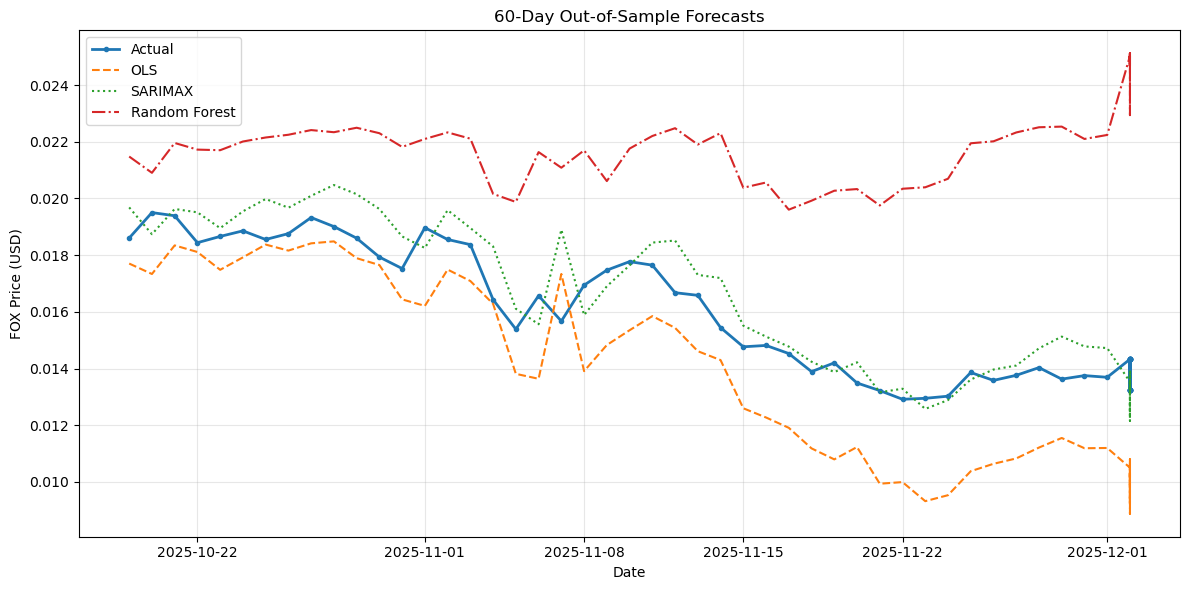

In [ ]:
# 3. Out-of-sample forecasting
horizon = 60
train, test = df.iloc[:-horizon], df.iloc[-horizon:]

Xtr, ytr = train[features], train['price_fox']
Xte, yte = test[features], test['price_fox']

# OLS
ols = LinearRegression().fit(Xtr, ytr)
pred_ols = ols.predict(Xte)

# SARIMAX forecast
sar_mod_train = sm.tsa.SARIMAX(
    endog=train['price_fox'],
    exog=train[features],
    order=(1, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sar_res_train = sar_mod_train.fit(disp=False)
pred_sar = sar_res_train.get_forecast(steps=horizon, exog=test[features]).predicted_mean

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(Xtr, ytr)
pred_rf = rf.predict(Xte)

# Compute RMSEs
print("=== Out-of-Sample Forecast RMSE (last 60 days) ===")
print(f"OLS:     {np.sqrt(mean_squared_error(yte, pred_ols)):.6f}")
print(f"SARIMAX: {np.sqrt(mean_squared_error(yte, pred_sar)):.6f}")
print(f"RF:      {np.sqrt(mean_squared_error(yte, pred_rf)):.6f}")

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(test['date'], yte, label='Actual', linewidth=2, marker='o', markersize=3)
plt.plot(test['date'], pred_ols, label='OLS', linestyle='--', linewidth=1.5)
plt.plot(test['date'], pred_sar, label='SARIMAX', linestyle=':', linewidth=1.5)
plt.plot(test['date'], pred_rf, label='Random Forest', linestyle='-.', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('FOX Price (USD)')
plt.title('60-Day Out-of-Sample Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== Random Forest Feature Importances ===
price_fox_lag1          0.949592
price_eth               0.028917
VIXCLS                  0.004434
vol7d_norm              0.004165
eth_7d_change           0.003061
price_btc               0.002343
btc_7d_change           0.002228
combined_twaps_fox      0.001876
combined_twaps_x_vol    0.001787
SP500                   0.001597
dtype: float64


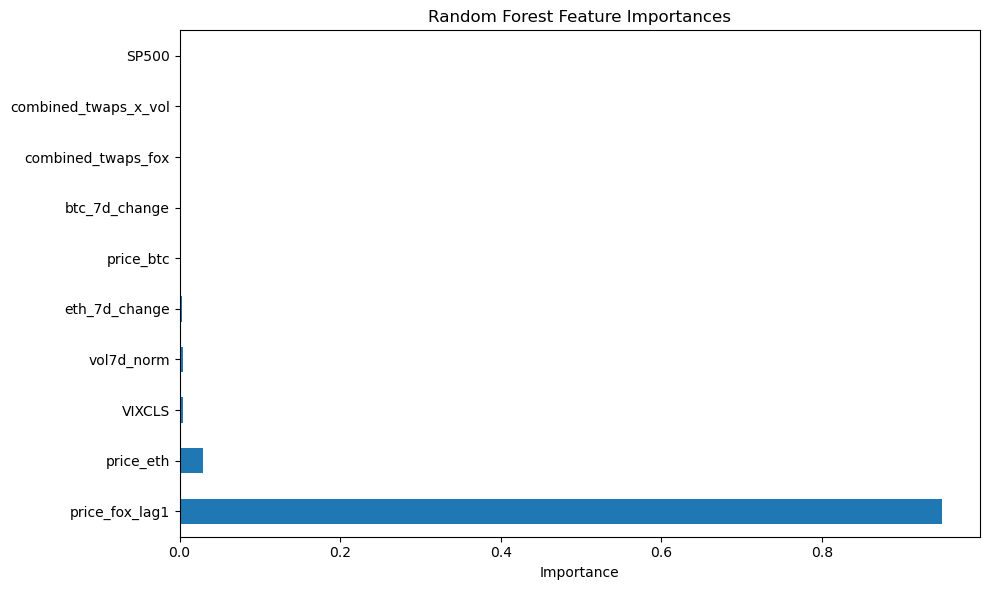

In [ ]:
# 4. Random Forest feature importances
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("=== Random Forest Feature Importances ===")
print(importances)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()


## Visualizations


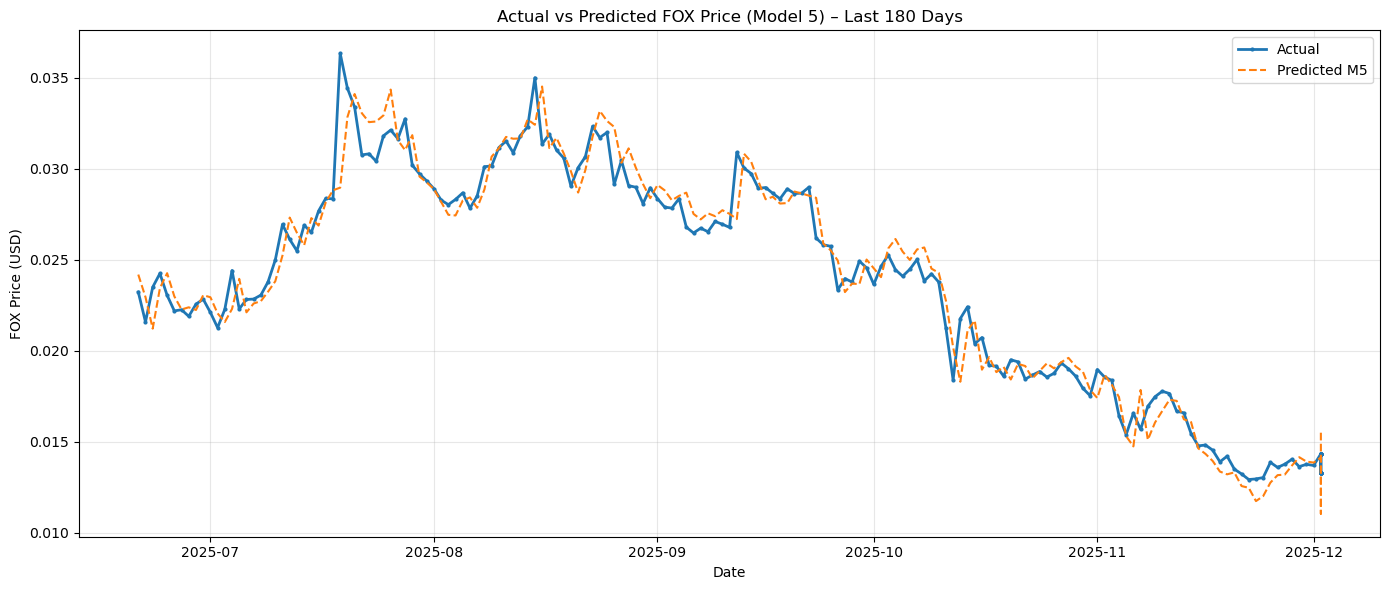

In [ ]:
# Combined plot: Actual vs Predicted for Model 5
if models_low['M5'] is not None and models_high['M5'] is not None:
    res5_low = models_low['M5'].fittedvalues
    res5_high = models_high['M5'].fittedvalues
    
    # Combine predictions
    pred_low = pd.Series(res5_low, index=df_low.index)
    pred_high = pd.Series(res5_high, index=df_high.index)
    df['pred_M5'] = pd.concat([pred_low, pred_high]).sort_index()
    
    # Plot last 180 days
    last = df.tail(180)
    plt.figure(figsize=(14, 6))
    plt.plot(last['date'], last['price_fox'], label='Actual', linewidth=2, marker='o', markersize=2)
    plt.plot(last['date'], last['pred_M5'], label='Predicted M5', linestyle='--', linewidth=1.5)
    plt.xlabel('Date')
    plt.ylabel('FOX Price (USD)')
    plt.title('Actual vs Predicted FOX Price (Model 5) – Last 180 Days')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


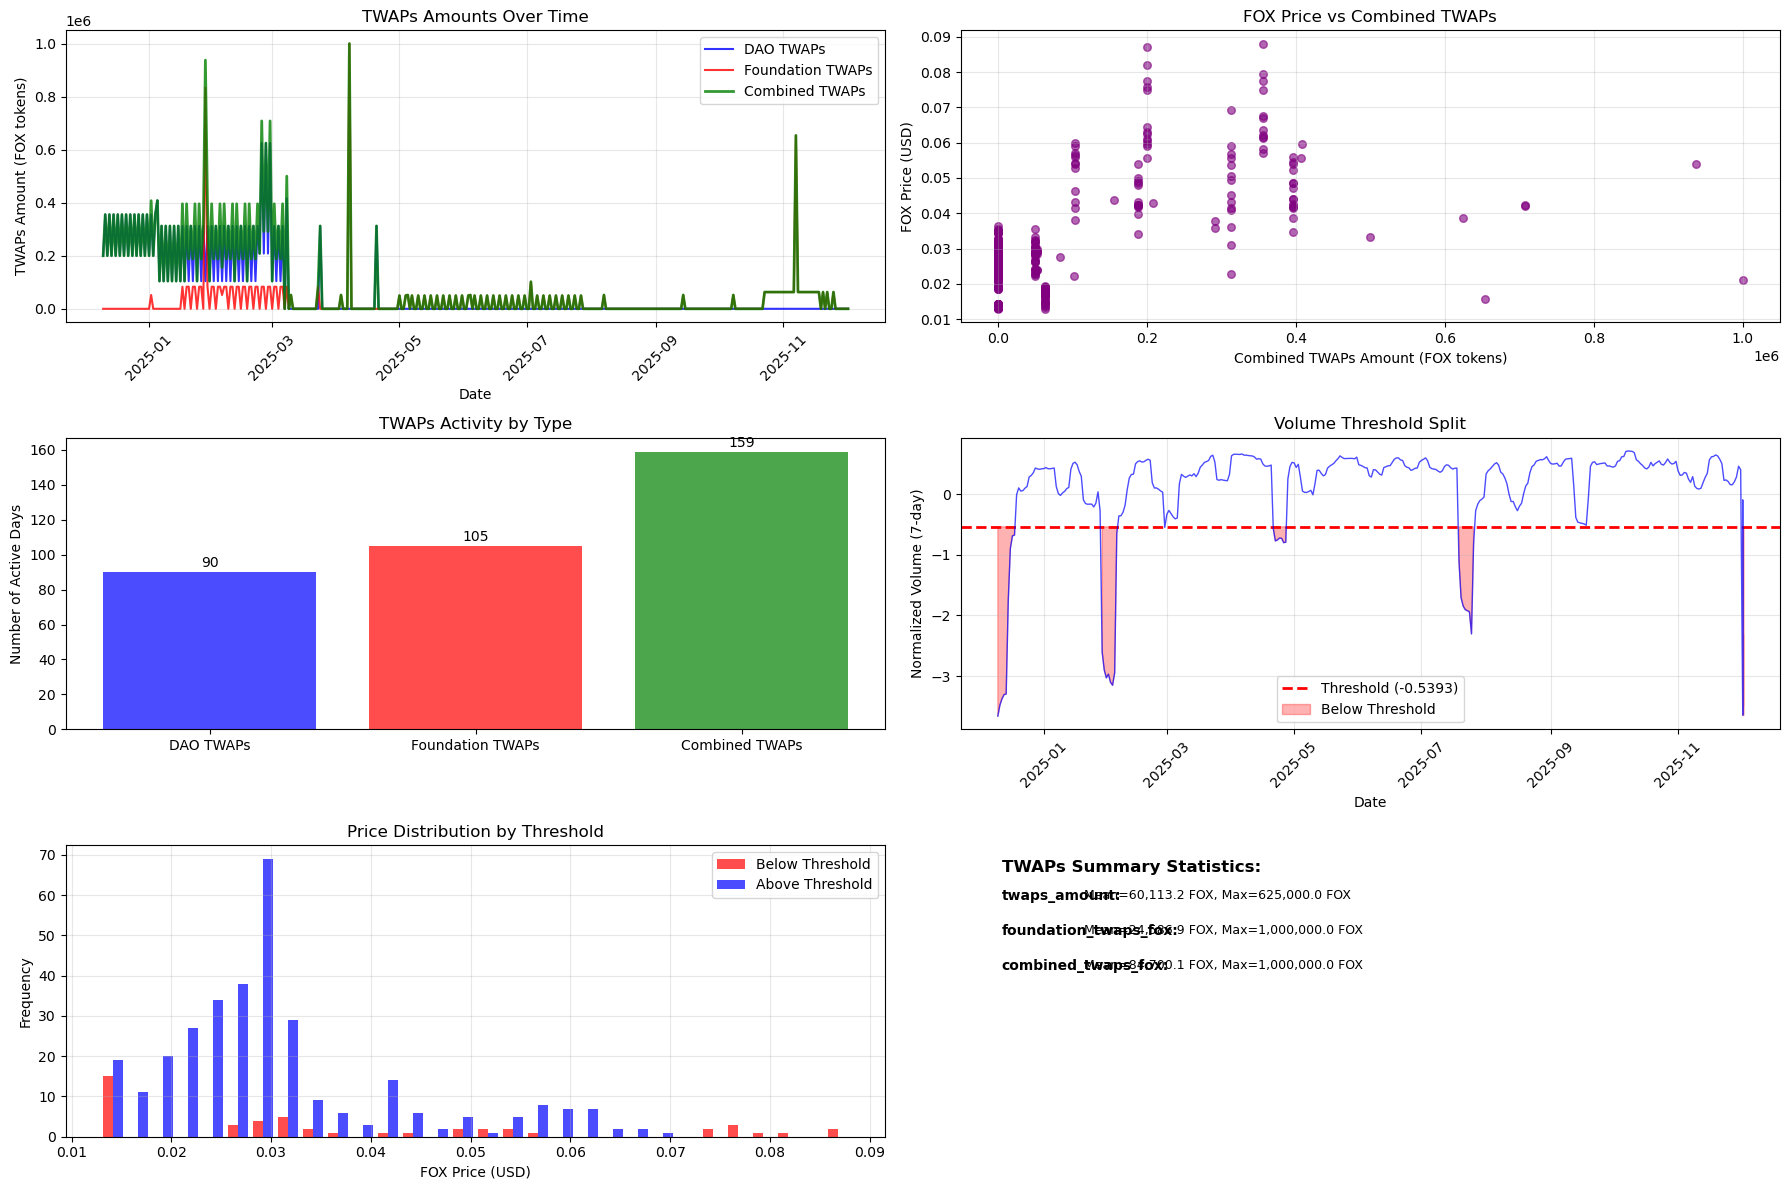

In [ ]:
# Comprehensive TWAPs visualization
fig, axes = plt.subplots(3, 2, figsize=(18, 12))

# 1. TWAPs amounts over time
axes[0, 0].plot(df['date'], df['twaps_amount'], label='DAO TWAPs', alpha=0.8, color='blue', linewidth=1.5)
axes[0, 0].plot(df['date'], df['foundation_twaps_fox'], label='Foundation TWAPs', alpha=0.8, color='red', linewidth=1.5)
axes[0, 0].plot(df['date'], df['combined_twaps_fox'], label='Combined TWAPs', alpha=0.8, color='green', linewidth=2)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('TWAPs Amount (FOX tokens)')
axes[0, 0].set_title('TWAPs Amounts Over Time')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Price vs Combined TWAPs
axes[0, 1].scatter(df['combined_twaps_fox'], df['price_fox'], alpha=0.6, color='purple', s=30)
axes[0, 1].set_xlabel('Combined TWAPs Amount (FOX tokens)')
axes[0, 1].set_ylabel('FOX Price (USD)')
axes[0, 1].set_title('FOX Price vs Combined TWAPs')
axes[0, 1].grid(True, alpha=0.3)

# 3. TWAPs activity by type
activity_data = [
    df['dao_twaps_active'].sum(),
    df['foundation_twaps_active'].sum(),
    df['combined_twaps_active'].sum()
]
activity_labels = ['DAO TWAPs', 'Foundation TWAPs', 'Combined TWAPs']
bars = axes[1, 0].bar(activity_labels, activity_data, color=['blue', 'red', 'green'], alpha=0.7)
axes[1, 0].set_ylabel('Number of Active Days')
axes[1, 0].set_title('TWAPs Activity by Type')
for bar, value in zip(bars, activity_data):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   str(value), ha='center', va='bottom')

# 4. Volume threshold visualization
axes[1, 1].axhline(THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD:.4f})')
axes[1, 1].plot(df['date'], df['vol7d_norm'], alpha=0.7, color='blue', linewidth=1)
axes[1, 1].fill_between(df['date'], THRESHOLD, df['vol7d_norm'], 
                       where=(df['vol7d_norm'] < THRESHOLD), alpha=0.3, color='red', label='Below Threshold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Normalized Volume (7-day)')
axes[1, 1].set_title('Volume Threshold Split')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# 5. Price distribution by threshold
price_low = df_low['price_fox']
price_high = df_high['price_fox']
axes[2, 0].hist([price_low, price_high], bins=30, alpha=0.7, 
                label=['Below Threshold', 'Above Threshold'], color=['red', 'blue'])
axes[2, 0].set_xlabel('FOX Price (USD)')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].set_title('Price Distribution by Threshold')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# 6. TWAPs summary statistics
twaps_summary = df[['twaps_amount', 'foundation_twaps_fox', 'combined_twaps_fox']].describe()
axes[2, 1].axis('off')
axes[2, 1].text(0.05, 0.95, 'TWAPs Summary Statistics:', transform=axes[2, 1].transAxes, 
               fontsize=12, fontweight='bold', verticalalignment='top')
y_pos = 0.85
for col in ['twaps_amount', 'foundation_twaps_fox', 'combined_twaps_fox']:
    mean_val = twaps_summary.loc['mean', col]
    max_val = twaps_summary.loc['max', col]
    axes[2, 1].text(0.05, y_pos, f'{col}:', transform=axes[2, 1].transAxes, 
                   fontsize=10, fontweight='bold', verticalalignment='top')
    axes[2, 1].text(0.15, y_pos, f'Mean={mean_val:,.1f} FOX, Max={max_val:,.1f} FOX', 
                   transform=axes[2, 1].transAxes, fontsize=9, verticalalignment='top')
    y_pos -= 0.12

plt.tight_layout()
plt.show()


## Summary Statistics


In [ ]:
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal observations: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nTWAPs Activity:")
print(f"  Days with DAO TWAPs: {df['dao_twaps_active'].sum()}")
print(f"  Days with Foundation TWAPs: {df['foundation_twaps_active'].sum()}")
print(f"  Days with Combined TWAPs: {df['combined_twaps_active'].sum()}")
print(f"  Days with both DAO and Foundation: {((df['dao_twaps_active'] == 1) & (df['foundation_twaps_active'] == 1)).sum()}")
print(f"\nTWAPs Amounts (FOX tokens):")
print(f"  Total DAO TWAPs: {df['twaps_amount'].sum():,.2f} FOX")
print(f"  Total Foundation TWAPs: {df['foundation_twaps_fox'].sum():,.2f} FOX")
print(f"  Total Combined TWAPs: {df['combined_twaps_fox'].sum():,.2f} FOX")
print(f"\nThreshold Analysis:")
print(f"  Below threshold: {len(df_low)} days ({len(df_low)/len(df)*100:.1f}%)")
print(f"  Above threshold: {len(df_high)} days ({len(df_high)/len(df)*100:.1f}%)")
print(f"\nModel Performance (M5):")
if models_low['M5'] is not None:
    print(f"  Below threshold R²: {models_low['M5'].rsquared:.4f}")
if models_high['M5'] is not None:
    print(f"  Above threshold R²: {models_high['M5'].rsquared:.4f}")


SUMMARY STATISTICS

Total observations: 373
Date range: 2024-12-10 to 2025-12-02

TWAPs Activity:
  Days with DAO TWAPs: 90
  Days with Foundation TWAPs: 105
  Days with Combined TWAPs: 159
  Days with both DAO and Foundation: 36

TWAPs Amounts (FOX tokens):
  Total DAO TWAPs: 22,422,222.39 FOX
  Total Foundation TWAPs: 9,170,918.76 FOX
  Total Combined TWAPs: 31,593,141.15 FOX

Threshold Analysis:
  Below threshold: 48 days (12.9%)
  Above threshold: 325 days (87.1%)

Model Performance (M5):
  Below threshold R²: 0.9877
  Above threshold R²: 0.9808
